<a href="https://colab.research.google.com/github/utsavnandi/Kaggle-SIIM-ISIC-Melanoma-Classification/blob/master/SIIM_ISIC_Melanoma_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## One-time


In [ ]:
%%time
!pip uninstall kaggle -y
!pip install kaggle==1.5.6 -q
!pip install -U git+https://github.com/albu/albumentations -q
!pip install -U git+https://github.com/rwightman/pytorch-image-models -q
!pip install neptune-client -q
!mkdir ~/.kaggle/
!cp ./kaggle.json  ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d shonenkov/melanoma-merged-external-data-512x512-jpeg
!unzip melanoma-merged-external-data-512x512-jpeg.zip -d ./data/    
!rm melanoma-merged-external-data-512x512-jpeg.zip
!kaggle competitions download siim-isic-melanoma-classification -f sample_submission.csv
!kaggle competitions download siim-isic-melanoma-classification -f test.csv
!kaggle competitions download siim-isic-melanoma-classification -f train.csv
!kaggle datasets download -d nroman/melanoma-hairs
!unzip train.csv -d ./data/ &> /dev/null
!unzip ./melanoma-hairs.zip -d ./data/
!rm ./melanoma-hairs.zip
!mv ./test.csv ./data/
!mv ./sample_submission.csv ./data/
!rm train.csv.zip
!mkdir ./logs/

## Setup

In [ ]:
import os
import gc
import time
import datetime
import random
from getpass import getpass
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from google.colab import auth
from google.cloud import storage

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.special import kl_div
from scipy.spatial.distance import jensenshannon

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.cuda.amp import GradScaler
import torchvision

import timm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import neptune

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(43)

#!nvidia-smi

In [ ]:
PROJECT_ID = getpass(prompt='Enter gcp project id: ')
bucket_name = getpass(prompt='Enter gcp bucket name: ')

if PROJECT_ID != '' and bucket_name !='':
    auth.authenticate_user()

!gcloud config set project {PROJECT_ID}

if PROJECT_ID != '' and bucket_name !='':
    storage_client = storage.Client(project=PROJECT_ID)

def upload_blob(source_file_name, destination_blob_name, bucket_name=bucket_name, PROJECT_ID=PROJECT_ID):
    """Uploads a file to the bucket."""
    storage_client = storage.Client(project=PROJECT_ID)
    bucket = storage_client.bucket(bucket_name)
    dt_now = datetime.datetime.now().strftime("%d_%B")
    destination_blob_name = 'siim-isic/'+dt_now+'/'+destination_blob_name
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(source_file_name)
    print("File {} uploaded to {}.".format(source_file_name, destination_blob_name))

In [ ]:
NEPTUNE_API_TOKEN = getpass(prompt='Enter neptune api token: ')

if NEPTUNE_API_TOKEN != '':
    os.environ['NEPTUNE_API_TOKEN'] = NEPTUNE_API_TOKEN
    log = True
    

In [ ]:
DATA_DIR = '/content/data/'

In [ ]:
df_train = pd.read_csv(DATA_DIR+'folds_13062020.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv').rename(columns={'image_name':'image_id'})
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

In [ ]:
df_train['fold'].value_counts()

In [ ]:
fold_no = 0
X_train = df_train[df_train['fold'] != fold_no][[col for col in df_train.columns if col != 'target']]
y_train = df_train[df_train['fold'] != fold_no][[col for col in df_train.columns if col == 'target']]
#y_train = pd.get_dummies(df_train[df_train['fold'] != fold_no][[col for col in df_train.columns if col == 'target']], columns=['target'])
X_val = df_train[df_train['fold'] == fold_no][[col for col in df_train.columns if col != 'target']]
y_val = df_train[df_train['fold'] == fold_no][[col for col in df_train.columns if col == 'target']]
#y_val = pd.get_dummies(df_train[df_train['fold'] == fold_no][[col for col in df_train.columns if col == 'target']], columns=['target'])

In [ ]:
np.where(y_train.values[:, 0]==1)[0]

In [ ]:
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_val', X_val.shape)
print('y_val', y_val.shape)

In [ ]:
print('Train target distribution: ')
print(y_train['target'].value_counts())
print('Val target distribution: ')
print(y_val['target'].value_counts())

## With External Dataset

In [ ]:
class MelanomaDataset(Dataset):

    def __init__(self, df, labels, istrain=False, transforms=None):
        super().__init__()
        self.image_id = df['image_id'].values
        self.transforms = transforms
        self.labels = labels.values
        self.neg_indices = np.where(self.labels[:, 0] == 0)[0]
        self.pos_indices = np.where(self.labels[:, 0] == 1)[0]
        self.istrain = istrain

    def __len__(self):
        return len(self.image_id)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        
        image, target = self.load_image(index)
        
        if self.transforms:
            image = self.transforms(image=image)['image']

        return image, target

    def load_image(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        image_name = DATA_DIR + f'512x512-dataset-melanoma/512x512-dataset-melanoma/{self.image_id[index]}.jpg'
        image = cv2.imread(image_name, cv2.IMREAD_COLOR).astype(np.uint8)
        target = self.labels[index].astype(np.float32)
        return image, target

    def get_rand_index(self):
        if np.random.random()>0.5:
            rand_index = np.random.choice(self.pos_indices)
        else:
            rand_index = np.random.choice(self.neg_indices)
        return rand_index

def get_datasets(data):
    X_train, y_train, X_val, y_val = data
    datasets = {}
    datasets['train'] = MelanomaDataset(
        X_train, y_train, istrain=True, transforms=get_train_transforms()
    )
    datasets['valid'] = MelanomaDataset(
        X_val, y_val, istrain=False, transforms=get_valid_transforms()
    )
    return datasets

class MelanomaEvalDataset(Dataset):
    def __init__(self, df, labels, isEval=True, transform=None):
        super().__init__()
        self.image_id = df['image_id'].values
        self.transform = transform
        self.isEval = isEval
        if not self.isEval:
            self.labels = labels.values

    def __len__(self):
        return len(self.image_id)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        
        if self.isEval:
            image_name = DATA_DIR + f'512x512-test/512x512-test/{self.image_id[index]}.jpg'
        else:
            image_name = DATA_DIR + f'512x512-dataset-melanoma/512x512-dataset-melanoma/{self.image_id[index]}.jpg'

        image = cv2.imread(image_name, cv2.IMREAD_COLOR).astype(np.uint8)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)

        if self.transform is not None:
            image = self.transform(image=image)['image']
        else:
            image = np.transpose(image, (2, 1, 0))

        if self.isEval:
            return image

        target = self.labels[index].astype(np.float32)
        return image, target
        

## Batch cutmix/mixup

In [ ]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix(data, targets1, alpha=1):
    indices = np.random.permutation(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = [targets1, shuffled_targets1, lam]
    return data, targets

def mixup(data, targets1, alpha=1):
    indices = np.random.permutation(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, lam]

    return data, targets


## Augmentations

In [ ]:
from albumentations.augmentations import functional as FA
from albumentations.core.transforms_interface import DualTransform

class GridMask(DualTransform):
    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = FA.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

In [ ]:
#%%writefile augmentations.txt
# Reference IMG_SIZE
# B0 - 224
# B1 - 240
# B2 - 260
# B3 - 300
# B4 - 380

# Transforms

IMG_SIZE = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

def get_train_transforms(p=1.0):
    return A.Compose(
        [
            A.OneOf(
                [
                    A.CenterCrop(2 * IMG_SIZE // 3, 2 * IMG_SIZE // 3, p=0.5),
                    A.CenterCrop(3 * IMG_SIZE // 4, 3 * IMG_SIZE // 4, p=0.5),
                ],
                p=0.33,
            ),
            A.Resize(
                IMG_SIZE, IMG_SIZE, interpolation=1, always_apply=True, p=1
            ),
            A.Flip(),
            A.Transpose(),
            GridMask(num_grid=(1, 4), rotate=15, p=0.33),
            A.OneOf(
                [
                    A.MedianBlur(blur_limit=3, p=0.5),
                    A.Blur(blur_limit=3, p=0.5),
                ],
                p=0.5,
            ),
            A.OneOf(
                [
                    A.ShiftScaleRotate(
                        interpolation=1,
                        shift_limit=0.05,
                        scale_limit=0.1,
                        rotate_limit=15,
                        p=0.5,
                    ),
                    A.IAAPiecewiseAffine(scale=(0.02, 0.04), p=0.5),
                ],
                p=0.33,
            ),
            A.OneOf(
                [
                    A.HueSaturationValue(
                        hue_shift_limit=20,
                        sat_shift_limit=30,
                        val_shift_limit=20,
                        p=0.5,
                    ),
                    A.RandomBrightnessContrast(p=0.5),
                ],
                p=0.5,
            ),
            A.MultiplicativeNoise(
                multiplier=[0.9, 1.1], elementwise=True, p=0.3
            ),
            A.Normalize(mean, std, max_pixel_value=255.0, always_apply=True),
            ToTensorV2(p=1.0),
        ],
        p=p,
    )

def get_valid_transforms():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE, interpolation=2, always_apply=True, p=1),
        A.Normalize(mean, std, max_pixel_value=255.0, always_apply=True),
        ToTensorV2(p=1.0),
    ])


In [ ]:
# not used
class AdvancedHairAugmentation:
    def __init__(self, hairs: int = 4, hairs_folder: str = ""):
        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def __call__(self, img):
        n_hairs = random.randint(0, self.hairs)

        if not n_hairs:
            return img

        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]

        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            dst = cv2.add(img_bg, hair_fg)
            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst

        return img

## Visualise Transforms

In [ ]:
def visualize_dataset(dataset, shuffle=True):
    labels_vcount = y_train['target'].value_counts()
    #labels_vcount = pd.Series(y_train).value_counts()
    class_counts = [labels_vcount[0].astype(np.float32), labels_vcount[1].astype(np.float32)]
    num_samples = sum(class_counts)
    class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
    weights = [class_weights[y_train['target'].values[i]] for i in range(int(num_samples))]
    sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

    dl = DataLoader(dt, batch_size=8, sampler=sampler)
    for images, targets in dl:
        images = images.to('cuda')
        targets = targets.to('cuda')
        #if np.random.rand()<0.5:
        #    images, targets = cutmix(images, targets)
        #else:
        #    images, targets = mixup(images, targets)
        #for i, (image, target, shuffled_target) in enumerate(zip(images, targets[0], targets[1])):
        #    print(image.shape)
        #    image = image.detach().cpu().numpy().transpose((1,2,0))
        #    plt.imshow(image.astype(np.uint8))
        #    plt.show()
        #    print('actual target', target)
        #    print('shuffled target', shuffled_target)
        #    print('---------------------------------')
        #    if i>9:
        #        break
        #break
        for i, (image, target) in enumerate(zip(images, targets)):
            image = image.detach().cpu().numpy().transpose((1,2,0))
            image = (image  * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
            plt.figure(figsize=(6,6))
            plt.axis('off')
            plt.imshow(image)
            plt.show()
            print('actual target', target)
            print('image shape', image.shape)
            if i==8:
                break
        break
#dt = MelanomaDataset(X_train[:32], y_train[:32], isEval=False, transform=strong_aug())
#dt = MelanomaDataset(X_train, y_train, isEval=False, transform=strong_aug())

dt = MelanomaDataset(X_train, y_train, istrain=True, transforms=get_train_transforms())
visualize_dataset(dt, False)

## Plot

In [ ]:
from scipy.spatial import distance

def plot_roc(y_true, y_pred, show=False):
    testy, lr_probs = y_true, y_pred
    ns_probs = [0 for _ in range(len(testy))]
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs) #lr_probs: predictions
    # plot the roc curve for the model
    plt.figure(figsize=(8,8))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, linestyle='-', label='Model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    #save
    filename = f'/content/logs/roc_curve_{datetime.datetime.now().strftime("%d-%m-%Y-%HH-%MM")}.png'
    plt.savefig(filename)
    # show the plot
    if show:
        plt.show()
    else:
        plt.clf()
    return filename


def draw_hist(y_true, y_pred, show=True):
    true_neg_indices = np.where(y_true[:, 0] == 0)[0]
    true_pos_indices = np.where(y_true[:, 0] == 1)[0]
    pred_true_pos = y_pred[true_pos_indices]
    pred_true_neg = y_pred[true_neg_indices]
    thresh = 0.2
    pred_true_pos_error_count = pred_true_pos[np.where(pred_true_pos<(1-thresh))[0]]
    pred_true_neg_error_count = pred_true_neg[np.where(pred_true_neg>(thresh))[0]]
    total_error_count = pred_true_pos_error_count.shape[0] + pred_true_neg_error_count.shape[0] 
    total_error_count_scaled = total_error_count/y_true.shape[0]
    # plot
    figure = plt.figure(figsize=(14,6))
    ax1 = plt.subplot(121)
    ax1.hist(pred_true_neg.T[0],bins=10)
    plt.ylim((0,2000))
    ax2 = plt.subplot(122)
    ax2.hist(pred_true_pos.T[0],bins=10)
    if show:
        plt.show()  
    return figure, total_error_count_scaled


## Model

In [ ]:
class EfficientNet(nn.Module):

    def __init__(self, name='tf_efficientnet_b0_ns'):
        super().__init__()
        self.model = timm.create_model(name, pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.model(x)

class Tf_efficientnet_b0_Mod(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b0', pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, int(in_features/2))
        self.bn_1 = nn.BatchNorm1d(int(in_features/2))
        self.relu_1 = nn.ReLU()
        self.drop_1 = nn.Dropout(0.2)
        self.fc_2 = nn.Linear(int(in_features/2), 1)

    def forward(self, x):
        x = self.model(x)
        x = self.bn_1(x)
        x = self.relu_1(x)
        x = self.drop_1(x)
        x = self.fc_2(x)
        return x

class Tf_efficientnet_b1_Mod(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b1', pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, int(in_features/2))
        self.bn_1 = nn.BatchNorm1d(int(in_features/2))
        self.relu_1 = nn.ReLU()
        self.drop_1 = nn.Dropout(0.2)
        self.fc_2 = nn.Linear(int(in_features/2), 1)

    def forward(self, x):
        x = self.model(x)
        x = self.bn_1(x)
        x = self.relu_1(x)
        x = self.drop_1(x)
        x = self.fc_2(x)
        return x

class Tf_efficientnet_b3(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b3', pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.model(x)

class Tf_efficientnet_b3_ns_Mod(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b3_ns', pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, int(in_features/2))
        self.bn_1 = nn.BatchNorm1d(int(in_features/2))
        self.relu_1 = nn.ReLU()
        self.drop_1 = nn.Dropout(0.2)
        self.fc_2 = nn.Linear(int(in_features/2), 1)

    def forward(self, x):
        x = self.model(x)
        x = self.bn_1(x)
        x = self.relu_1(x)
        x = self.drop_1(x)
        x = self.fc_2(x)
        return x

class Tf_efficientnet_b3_ns_Mod_v2(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b3_ns', pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, in_features)
        self.relu_1 = nn.ReLU()
        self.bn_1 = nn.BatchNorm1d(in_features)
        self.fc_1 = nn.Linear(in_features, int(in_features/2))
        self.bn_2 = nn.BatchNorm1d(int(in_features/2))
        self.fc_2 = nn.Linear(int(in_features/2), 1)

    def forward(self, x):
        x = self.model(x)
        x = self.relu_1(x)
        x = self.bn_1(x)
        x = self.fc_1(x)
        x = self.bn_2(x)
        x = self.fc_2(x)
        return x



## Custom Losses

In [ ]:
# Wrong implementation
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

from torch.nn import functional as F

def sigmoid_focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = 0.75,
    gamma: float = 1.75,
    reduction: str = "mean"
) -> torch.Tensor:
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.
    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha: (optional) Weighting factor in range (0,1) to balance
                positive vs negative examples. Default = -1 (no weighting).
        gamma: Exponent of the modulating factor (1 - p_t) to
               balance easy vs hard examples.
        reduction: 'none' | 'mean' | 'sum'
                 'none': No reduction will be applied to the output.
                 'mean': The output will be averaged.
                 'sum': The output will be summed.
    Returns:
        Loss tensor with the reduction option applied.
    """
    p = torch.sigmoid(inputs)
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    if reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()

    return loss

class CutMixCrossEntropyLoss(nn.Module):
    def __init__(self, size_average=True):
        super().__init__()
        self.size_average = size_average

    def forward(self, input, target):
        if len(target.size()) == 1:
            target = torch.nn.functional.one_hot(target, num_classes=input.size(-1))
            target = target.float()
        return cross_entropy(input, target, self.size_average)

def cross_entropy(input, target, size_average=True):
    """ Cross entropy that accepts soft targets
    Args:
         pred: predictions for neural network
         targets: targets, can be soft
         size_average: if false, sum is returned instead of mean
    Examples::
        input = torch.FloatTensor([[1.1, 2.8, 1.3], [1.1, 2.1, 4.8]])
        input = torch.autograd.Variable(out, requires_grad=True)
        target = torch.FloatTensor([[0.05, 0.9, 0.05], [0.05, 0.05, 0.9]])
        target = torch.autograd.Variable(y1)
        loss = cross_entropy(input, target)
        loss.backward()
    """
    logsoftmax = torch.nn.LogSoftmax(dim=1)
    if size_average:
        return torch.mean(torch.sum(-target * logsoftmax(input), dim=1))
    else:
        return torch.sum(torch.sum(-target * logsoftmax(input), dim=1))

def ohem_loss(cls_pred, cls_target, rate):
    ohem_cls_loss = F.binary_cross_entropy_with_logits(cls_pred, cls_target, reduction='none')
    batch_size = cls_pred.size(0)
    sorted_ohem_loss, idx = torch.sort(ohem_cls_loss, descending=True)
    keep_num = min(sorted_ohem_loss.size()[0], int(batch_size*rate))
    if keep_num < sorted_ohem_loss.size()[0]:
        keep_idx_cuda = idx[:keep_num]
        ohem_cls_loss = ohem_cls_loss[keep_idx_cuda]
    cls_loss = ohem_cls_loss.sum() / keep_num
    return cls_loss

# batch wise
def cutmix_mixup_criterion(
    preds1, targets, rate=0.7, epsilon=0.05, loss_type=None,
    alpha=-1, gamma = 2.0
):
    targets1, targets2, lam = targets[0], targets[1], targets[2]
    if loss_type is None:
        if rate>0:
            loss = lam * smooth_ohem_criterion(preds1, targets1, rate, epsilon) 
            + (1 - lam) * smooth_ohem_criterion(preds1, targets2, rate, epsilon)
        else:
            loss = lam * smooth_criterion(preds1, targets1, epsilon) 
            + (1 - lam) * smooth_criterion(preds1, targets2, epsilon)
    elif loss_type=='focal':
        loss = lam * sigmoid_focal_loss(preds1, targets1, alpha, gamma) 
        + (1 - lam) * sigmoid_focal_loss(preds1, targets2, alpha, gamma)
    return loss

def smooth_ohem_criterion(y_pred, y_true, rate, e):
    e = torch.tensor(e).to(device)
    y_true = torch.where(y_true == 0, e, y_true)
    y_true = torch.where(y_true == 1, (1-e), y_true)
    return ohem_loss(y_pred, y_true, rate)

def smooth_criterion(y_pred, y_true, e=0.05):
    e = torch.tensor(e).to('device')
    y_true = torch.where(y_true == 0, e, y_true)
    y_true = torch.where(y_true == 1, (1-e), y_true)
    return nn.BCEWithLogitsLoss()(y_pred, y_true)

def bce_criterion(y_pred, y_true):
    return nn.BCEWithLogitsLoss()(y_pred, y_true)

def cutmix_ce_criterion(y_pred, y_true):
    return CutMixCrossEntropyLoss()(y_pred, y_true)

def focal_criterion(y_pred, y_true):
    return FocalLoss(alpha=(43997/4384))(y_pred, y_true)


## Train script

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def train_one_epoch(loader, model, optimizer, epoch, scheduler=None, scaler=None, log=True):
    model.train()
    running_loss = 0.0
    for idx, (images, targets) in tqdm(enumerate(loader), total=len(loader)): #
        images = images.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        y_pred = model(images.float())
        loss = sigmoid_focal_loss(y_pred, targets, FLAGS['alpha'], FLAGS['gamma'])
        running_loss += float(loss)
        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        if scheduler is not None:
            scheduler.step()
        if log and (idx+1) % FLAGS['log_interval'] == 0:
            neptune.log_metric("Loss/train", float(loss))

    return running_loss/len(loader)

def val_one_epoch(loader, model):
    model.eval()
    running_loss = 0.0
    y_preds_list = []
    targets_list = []
    with torch.no_grad():
        for idx, (images, targets) in tqdm(enumerate(loader), total=len(loader)):
            images = images.to(device)
            targets = targets.to(device)#.unsqueeze(1)
            y_pred = model(images.float())
            loss = sigmoid_focal_loss(y_pred, targets, FLAGS['alpha'], FLAGS['gamma'])
            running_loss += float(loss)
            y_preds_list.append(torch.sigmoid(y_pred).cpu().numpy())
            targets_list.append(targets.cpu().numpy())
        y_true = np.vstack(targets_list)
        y_pred = np.vstack(y_preds_list)
        auc_score = roc_auc_score(y_true, y_pred) # add [:, 1] for cross entropy
        roc_plot = plot_roc(y_true, y_pred) # add [:, 1] for cross entropy
        hist, error_scaled = draw_hist(y_true, y_pred)
        print(f'roc_auc_score: {auc_score:.5f}')
        print(f'average loss for val epoch: {running_loss/len(loader):.5f}')
        print(f'scaled error: {error_scaled:.5f}')
        jsd = jensenshannon(y_true, y_pred, 2.0)[0]
        print(f"JS distance: {jsd:.5f}")
        kld = kl_div(y_true, y_pred).mean()
        print(f'mean KL divergence: {kld:.5f}')
    return running_loss/len(loader), auc_score, roc_plot, hist, error_scaled, jsd, kld
   
def save_upload(model, optimizer, score, epoch, fold=None, exp_name='model'):
    if fold:
        NAME = exp_name+f'_fold_{str(fold+1)}_{str(epoch+1)}.ckpt'
    NAME = exp_name+f'_{str(epoch+1)}.ckpt'
    MODEL_PATH = NAME
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, MODEL_PATH)
    print(f"Saved ckpt for epoch {epoch+1}, score: {score:.5f}")
    upload_blob(MODEL_PATH, NAME)
    print(f"Uploaded ckpt for epoch {epoch+1}")


In [ ]:
def fit(data, fold=None, log=True):

    best_score = 0.0

    model = EfficientNet('tf_efficientnet_b0_ns').to(device)
    #model.load_state_dict(
    #    torch.load(
    #        '/content/siim-isic_efficientnet_b0_15.ckpt'
    #        )['model_state_dict']
    #)
    if log:
        neptune.init('utsav/SIIM-ISIC', api_token=NEPTUNE_API_TOKEN)
        neptune.create_experiment(
            FLAGS['exp_name'], exp_description, params=FLAGS,
            upload_source_files='*.txt'
        )

    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=FLAGS['learning_rate'], 
        weight_decay=FLAGS['weight_decay']
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.5, cooldown=0, mode='min',
        patience=3, verbose=True, min_lr=1e-8
    )
    
    datasets = get_datasets(data)
    
    #sampler - not needed for focal loss
    #labels_vcount = y_train['target'].value_counts()
    #class_counts = [labels_vcount[0].astype(np.float32), labels_vcount[1].astype(np.float32)]
    #num_samples = sum(class_counts)
    #class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
    #weights = [class_weights[y_train['target'].values[i]] for i in range(int(num_samples))]
    #sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
    
    #loaders
    train_loader = DataLoader(
        datasets['train'], batch_size=FLAGS['batch_size'], 
        num_workers=FLAGS['num_workers'],
        shuffle=True, # sampler=sampler,
        pin_memory=True,
    )
    val_loader = DataLoader(
        datasets['valid'], batch_size=FLAGS['batch_size'] * 2, shuffle=False, 
        num_workers=FLAGS['num_workers'], drop_last=True
    )

    scaler = GradScaler()
    #train loop
    for epoch in range(0, FLAGS['num_epochs']):

        print('-'*27 + f'Epoch #{epoch+1} started' + '-'*27)

        train_loss = train_one_epoch(
            train_loader, 
            model, optimizer, 
            epoch, scheduler=None, 
            scaler=scaler, log=log
        )
        print(f'\nAverage loss for epoch #{epoch+1} : {train_loss:.5f}')

        val_output = val_one_epoch(val_loader, model)
        val_loss, auc_score, roc_plot, hist, error_scaled, jsd, kld = val_output
        scheduler.step(error_scaled)

        #logs
        if log:
            neptune.log_metric('AUC/val', auc_score)
            neptune.log_image('ROC/val', roc_plot)
            neptune.log_metric('Loss/val', val_loss)
            neptune.log_image('hist/val', hist)
            neptune.log_metric('error_scaled/val', error_scaled)
            neptune.log_metric('jsd/val', jsd)
            neptune.log_metric('kld/val', kld)

        #checkpoint+upload
        save_upload(
            model, optimizer, 
            auc_score, epoch,
            fold, exp_name=FLAGS['exp_name']
        )

        print('-'*28 + f'Epoch #{epoch+1} ended' + '-'*28)
    
    if log:
        neptune.stop()
    
    return model


## Train

In [ ]:
FLAGS = {}
FLAGS['batch_size'] = 32
FLAGS['num_workers'] = 4
FLAGS['learning_rate'] = 1e-4
FLAGS['num_epochs'] = 30
FLAGS['weight_decay'] = 1e-3
FLAGS['log_interval'] = 25
FLAGS['img_size'] = IMG_SIZE
FLAGS['loss'] = 'focal'
FLAGS['optimizer'] = 'AdamW'
FLAGS['exp_name'] = 'efficientnet_b0'
FLAGS['fold'] = 0
FLAGS['alpha'] = (41906 / (41906 + 3874)) #0.9153778942769768
FLAGS['gamma'] = 2
exp_description = '''
efficientnet_b0 with base head,
Extra Data
No Sampler,
changed aug,
imsize 224
'''

fold_no = FLAGS['fold']
X_train = df_train[df_train['fold'] != fold_no][[col for col in df_train.columns if col != 'target']]
y_train = df_train[df_train['fold'] != fold_no][[col for col in df_train.columns if col == 'target']]
X_val = df_train[df_train['fold'] == fold_no][[col for col in df_train.columns if col != 'target']]
y_val = df_train[df_train['fold'] == fold_no][[col for col in df_train.columns if col == 'target']]
data = X_train, y_train, X_val, y_val
try:
    trained_model = fit(data, FLAGS['fold'], log=True)
except Exception as e:
    if log:
        neptune.stop()
    print(e)
except KeyboardInterrupt:
    if log:
       neptune.stop()


## Inference

In [ ]:
# upload_blob('/content/siim-isic_Tf_efficientnet_b2_ns_10.ckpt', 'new_upload_e2_10.ckpt')
# upload_blob('/content/siim-isic_Tf_efficientnet_b2_ns_8.ckpt', 'new_upload_e2_8.ckpt')

In [ ]:
#trained_model = ResNet34Mod()
def run_test(model, test_images, ckpts):
    agg_predictions = []
    for ckpt in ckpts:
        model.load_state_dict(torch.load(ckpt)['model_state_dict'])
        model.to(device).eval()
        test_dataset = MelanomaEvalDataset(test_images, labels=None, isEval=True, transform=get_valid_transforms())
        test_data_loader = DataLoader(
            test_dataset, batch_size=256, shuffle=False, 
            num_workers=4, pin_memory=True
        )
        predictions = []
        with torch.no_grad():
            for images in tqdm(test_data_loader, total=len(test_data_loader)):
                images = images.to(device)
                y_pred = torch.sigmoid(model(images.float()))
                predictions.append(y_pred.cpu().numpy())
        predictions = np.vstack(predictions)
        plt.hist(predictions.T[0],bins=100)
        plt.ylim((0,500))
        plt.show()
        agg_predictions.append(predictions)
    #can be vectorized
    #avg_predictions = agg_predictions[0]
    #avg_predictions = 0
    avg_predictions = 0
    for predictions in agg_predictions:
        #avg_predictions = np.multiply(avg_predictions, predictions).astype(np.float64)
        avg_predictions = np.add(avg_predictions, predictions).astype(np.float64)
    #avg_predictions = np.power(avg_predictions, (1/float(len(agg_predictions))))
    avg_predictions = np.divide(avg_predictions, float(len(agg_predictions)))
    print('average:')
    plt.hist(avg_predictions.T[0], bins=100)
    plt.ylim((0,500))
    plt.show()
    return avg_predictions

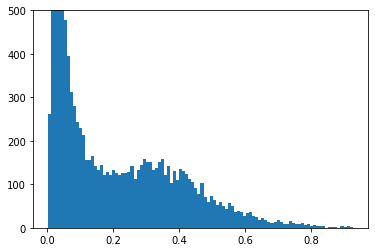

average:


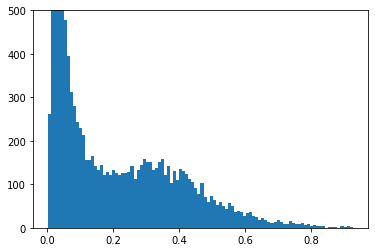

In [ ]:
ckpts = [
         '/content/efficientnet_b0_16.ckpt'
        ]
trained_model = EfficientNet('tf_efficientnet_b0_ns').to(device)
avg_predictions = run_test(trained_model, df_test, ckpts)

In [ ]:
pd.Series(avg_predictions.T[0]).describe()

count    10982.000000
mean         0.213347
std          0.183402
min          0.004614
25%          0.052288
50%          0.157710
75%          0.344794
max          0.925111
dtype: float64

In [ ]:
pd.Series(np.where(avg_predictions>0.5,1,0).T[0]).value_counts()

0    10084
1      898
dtype: int64

In [ ]:
sample_submission.target = avg_predictions.T[0].T

In [ ]:
sample_submission.to_csv('submission.csv', index=False)

In [ ]:
pd.read_csv('submission.csv')

,image_name,target
0,ISIC_0052060,0.022483
1,ISIC_0052349,0.033522
2,ISIC_0058510,0.087246
3,ISIC_0073313,0.017514
4,ISIC_0073502,0.117519
...,...,...
10977,ISIC_9992485,0.080649
10978,ISIC_9996992,0.254249
10979,ISIC_9997917,0.473851
10980,ISIC_9998234,0.042875


## Submit to Kaggle

In [ ]:
!kaggle competitions submit -c siim-isic-melanoma-classification -f submission.csv -m 'focal test exp 115'

100% 351k/351k [00:00<00:00, 1.35MB/s]
Successfully submitted to SIIM-ISIC Melanoma Classification

In [ ]:
!kaggle competitions submissions siim-isic-melanoma-classification

fileName             date                 description                                                                     status    publicScore  privateScore  
-------------------  -------------------  ------------------------------------------------------------------------------  --------  -----------  ------------  
submission.csv       2020-07-05 08:51:14  focal test exp 115                                                              complete  0.901        None          
submission.csv       2020-07-05 04:17:45  focal test exp 112+114                                                          complete  0.903        None          
submission.csv       2020-07-05 04:11:56  focal test exp 114                                                              complete  0.894        None          
submission.csv       2020-07-04 18:41:39  focal test exp 112                                                              complete  0.903        None          
submission.csv       2020-07-02 16:09:08